# Coursera: Data Analysis Tools – Assignment 2
For this assignment, the task was to conduct Chi Square tests of independence to find out if categorical variables are related. I chose the following combinations of variables to explore:
* Health perception (good / not good) -> Animal phobia (pure / mixed)
* Region of origin -> Animal phobia (Y / N)
* Region of origin -> Animal phobia (pure / mixed)

This assignment is based on some of the materials provided within the Coursera course, but also relies on the lessons from [Python for Data Science](https://pythonfordatascience.org/) website, which seems more reliable in terms of Python application to data analysis (style and conventions in the first place).

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import scipy.stats

from global_vars import *
from reference import *


NESARC = r"C:\Users\USER\Documents\Courses\Coursera\dai\datasets\nesarc\nesarc_pds.csv"


# Load data
data = pd.read_csv(NESARC, low_memory=False)

# Convert necessary values to numbers
data[ANIMALS_MAP[CODE]] = pd.to_numeric(data[ANIMALS_MAP[CODE]], errors='coerce')

Create a distinction between pure and mixed animal phobia.

In [2]:
for phobia in ALL_SPECIFIC_PHOBIAS:
    data[phobia[CODE] + '_NEW'] = data[phobia[CODE]].replace([2, 9], 0)
sp_new_list = [entry[CODE] + '_NEW' for entry in ALL_SPECIFIC_PHOBIAS]  # creating a list of names for the new columns
data[APPUREMIXED] = data.loc[:, sp_new_list].sum(axis=1)
condition_for_replace = data[APPUREMIXED] > 1
data.loc[condition_for_replace, APPUREMIXED] = 0  # replace values > 1 with 0
appuremixed_freq = data[data[ANIMALS_MAP[CODE]] == 1][APPUREMIXED].value_counts(sort=False, dropna=False)
appuremixed_percent = data[data[ANIMALS_MAP[CODE]] == 1][APPUREMIXED].value_counts(sort=False, dropna=False, normalize=True)

print('Frequencies, percentages for pure and mixed animal phobia')
print(pd.concat(dict(Frequencies=appuremixed_freq.rename({1: 'Pure', 0: 'Mixed'}),
                     Percentages=appuremixed_percent.rename({1: 'Pure', 0: 'Mixed'})), axis=1))

Frequencies, percentages for pure and mixed animal phobia
       Frequencies  Percentages
Mixed         6836     0.751787
Pure          2257     0.248213


Create subset for only those with animal phobia.

In [3]:
condition_ap = data[ANIMALS_MAP[CODE]] == 1
subset_ap = data[condition_ap].copy()  # Make a subset of those with animal phobia

Create binary health perception variable.

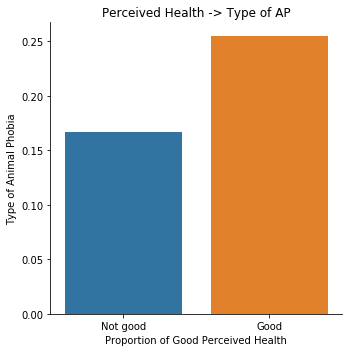

In [4]:
def sort_health(row):
    '''
    Recoding values for perceived health
    :param row: row of a dataset
    :return: code value (int)
    '''
    good = [1, 2, 3, 4]
    if row[HEALTH_MAP[CODE]] in good:
        return 1
    else:
        return 0
    
subset_ap['HEALTHBINARY'] = subset_ap.apply(lambda row: sort_health(row), axis=1)

subset_ap['HEALTHBINARY'] = subset_ap['HEALTHBINARY'].astype('category')
subset_ap['HEALTHBINARY'] = subset_ap['HEALTHBINARY'].cat.rename_categories(['Not good', 'Good'])

seaborn.catplot(x='HEALTHBINARY', y=APPUREMIXED, kind='bar', ci=None, data=subset_ap)
plt.xlabel('Proportion of Good Perceived Health')
plt.ylabel('Type of Animal Phobia')

plt.title('Perceived Health -> Type of AP')
# plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

Create contigency table for Perceived Health and Pure/Mixed Animal Phobia.

In [5]:
ph_ap_crosstable = pd.crosstab(subset_ap[APPUREMIXED], subset_ap['HEALTHBINARY'])
print(ph_ap_crosstable)

HEALTHBINARY  Not good  Good
APPUREMIXED                 
0                  565  6271
1                  113  2144


In [6]:
# Get column percentages
col_sum=ph_ap_crosstable.sum(axis=0)  # column sums
col_percent=ph_ap_crosstable / col_sum
print(col_percent)

HEALTHBINARY  Not good      Good
APPUREMIXED                     
0             0.833333  0.745217
1             0.166667  0.254783


Get Chi Square stats.  
Question: If a respondent with animal phobia perceives their health as good, is it reasonable to expect that their animal phobia is pure?
* H<sub>0</sub>: There is no relationship between perceived health and animal phobia.
* H<sub>A</sub>: The two variables are not related.

In [7]:
ph_ap_chisquare = scipy.stats.chi2_contingency(ph_ap_crosstable)
print ('chi-square value, p-value, expected counts')
print (ph_ap_chisquare)

chi-square value, p-value, expected counts
(25.637793619550834, 4.1189268158301394e-07, 1, array([[ 509.71164632, 6326.28835368],
       [ 168.28835368, 2088.71164632]]))


Conclusion: retain H<sub>0</sub>. The difference in health perception for the respondents with pure and mixed animal phobia is insignificant, i.e. the two variables are not related.

Now for the regions of origin regarding AP. First, on general terms (both, pure and mixed AP).

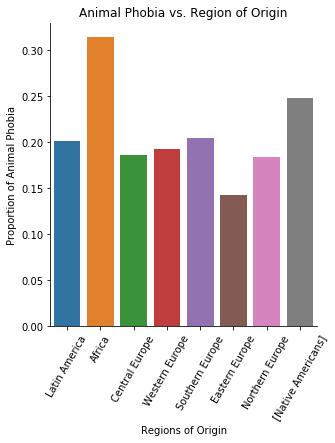

In [8]:
data[ORIGIN_MAP[CODE]] = pd.to_numeric(data[ORIGIN_MAP[CODE]], errors='coerce')

# Make a subset for the most frequent origins
condition_origin = data[ORIGIN_MAP[CODE]].isin(REGIONS)
subset_origin = data[condition_origin].copy()

# Create a column with region names
subset_origin['REGION'] = subset_origin[ORIGIN_MAP[CODE]].map(REGIONS)

subset_origin[ANIMALS_MAP[CODE]] = subset_origin[ANIMALS_MAP[CODE]].replace(9, np.nan)
subset_origin[ANIMALS_MAP[CODE]] = subset_origin[ANIMALS_MAP[CODE]].replace(2, 0)
subset_origin[ANIMALS_MAP[CODE]] = subset_origin[ANIMALS_MAP[CODE]].astype('category')
subset_origin[ANIMALS_MAP[CODE]] = pd.to_numeric(subset_origin[ANIMALS_MAP[CODE]], errors='coerce')

origins_ap_df = subset_origin[[ANIMALS_MAP[CODE], 'REGION']]

# Bivariate chart: Region of Origin -> Experience of Animal Phobia (both mixed and pure)
seaborn.catplot(x='REGION', y=ANIMALS_MAP[CODE], kind='bar', ci=None, data=origins_ap_df)
plt.xlabel('Regions of Origin')
plt.ylabel('Proportion of Animal Phobia')
plt.title('Animal Phobia vs. Region of Origin')
plt.xticks(rotation=60)
plt.show()

Create a contigency table for the case.

In [9]:
ro_ap_crosstable = pd.crosstab(origins_ap_df[ANIMALS_MAP[CODE]], origins_ap_df['REGION'])
print(ro_ap_crosstable)

REGION  Africa  Central Europe  Eastern Europe  Latin America  \
S8Q1A1                                                          
0.0       5054            5351             348           5298   
1.0       2316            1223              58           1338   

REGION  Northern Europe  Southern Europe  Western Europe  [Native Americans]  
S8Q1A1                                                                        
0.0                 712             1592            7350                 711  
1.0                 161              409            1755                 235  


Get general Chi Square stats to find out if there is any relationship between the two variables.
* H<sub>0</sub>: There is no relationship;
* H<sub>A</sub>: There is some relationship.

In [10]:
ro_ap_chisquare = scipy.stats.chi2_contingency(ro_ap_crosstable)
print ('chi-square value, p-value, expected counts')
print (ro_ap_chisquare)

chi-square value, p-value, expected counts
(504.0635623961649, 1.072413740307958e-104, 7, array([[5741.08460382, 5121.01630739,  316.26599039, 5169.31308425,
         680.04977736, 1558.73952405, 7092.61537554,  736.91533721],
       [1628.91539618, 1452.98369261,   89.73400961, 1466.68691575,
         192.95022264,  442.26047595, 2012.38462446,  209.08466279]]))


P-value is very small, which shows that there is a significant difference between some of the results and therefore supports H<sub>A</sub>. The next goal is to establish where this difference is located by conducting post hoc tests.  
Create a new dataframe with all relevant categories represented as binary (0/1) columns.

In [11]:
dummies = pd.get_dummies(origins_ap_df['REGION'])  # type: dataframe
print(dummies.head())

   Africa  Central Europe  Eastern Europe  Latin America  Northern Europe  \
0       0               0               0              1                0   
1       0               0               0              1                0   
2       0               0               0              1                0   
3       0               0               0              1                0   
5       1               0               0              0                0   

   Southern Europe  Western Europe  [Native Americans]  
0                0               0                   0  
1                0               0                   0  
2                0               0                   0  
3                0               0                   0  
5                0               0                   0  


For each such column run chi2 test with adjusted Bonferroni p-value. We have 8 regions of origin, ergo 8 hypotheses to test, so based on α = .05, the adjusted p-value will be `.05 / 8 = .00625`.

In [12]:
for column in dummies:
    crosstab = pd.crosstab(dummies[column], origins_ap_df[ANIMALS_MAP[CODE]])
    print(crosstab, '\n')
    chi2, p_value, dof, expected = scipy.stats.chi2_contingency(crosstab)
    print('Chi2: {}\nP-value: {}\nDegrees of freedom: {}\nExpected: {}'.format(chi2, p_value, dof, expected))

S8Q1A1    0.0   1.0
Africa             
0       21362  5179
1        5054  2316 

Chi2: 474.6641680909471
P-value: 3.0961513069076814e-105
Degrees of freedom: 1
Expected: [[20674.91539618  5866.08460382]
 [ 5741.08460382  1628.91539618]]
S8Q1A1            0.0   1.0
Central Europe             
0               21065  6272
1                5351  1223 

Chi2: 57.71732620480639
P-value: 3.026253902723936e-14
Degrees of freedom: 1
Expected: [[21294.98369261  6042.01630739]
 [ 5121.01630739  1452.98369261]]
S8Q1A1            0.0   1.0
Eastern Europe             
0               26068  7437
1                 348    58 

Chi2: 14.125470448000387
P-value: 0.00017101245656933465
Degrees of freedom: 1
Expected: [[26099.73400961  7405.26599039]
 [  316.26599039    89.73400961]]
S8Q1A1           0.0   1.0
Latin America             
0              21118  6157
1               5298  1338 

Chi2: 17.881311030598127
P-value: 2.3511872578095437e-05
Degrees of freedom: 1
Expected: [[21246.68691575  6028.31

The post hoc tests show significant difference for the following regions of origin:
* Africa (p-value = 3.0961513069076814e-105)
* Central Europe (p-value = 3.026253902723936e-14)
* Eastern  Europe (p-value = 0.00017101245656933465)
* Latin America (p-value = 2.3511872578095437e-05)
* Western Europe (p-value = 3.300001574945148e-14)

Interestingly, the difference for the \[Native Americans\] (rather remarkable in the chart above) appears non-significant (p-value = .04 vs. .006 threashold).

Last step is establish if there is any relationship between pure and mixed AP disreibution and the region of origin.

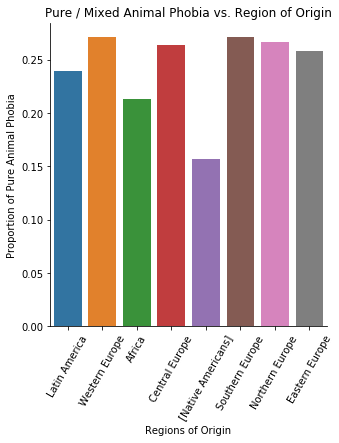

In [13]:
subset_origin_ap = subset_origin[subset_origin[ANIMALS_MAP[CODE]] == 1].copy()
subset_origin_ap[APPUREMIXED] = pd.to_numeric(subset_origin[APPUREMIXED], errors='coerce')
origins_appm_df = subset_origin_ap[[APPUREMIXED, 'REGION']].dropna()

# Bivariate chart: Region of Origin -> Type of Animal Phobia (mixed or pure)
seaborn.catplot(x='REGION', y=APPUREMIXED, kind='bar', ci=None, data=origins_appm_df)
plt.xlabel('Regions of Origin')
plt.ylabel('Proportion of Pure Animal Phobia')
plt.title('Pure / Mixed Animal Phobia vs. Region of Origin')
plt.xticks(rotation=60)
plt.show()

In [14]:
# Make crosstab
ro_appm_crosstable = pd.crosstab(origins_appm_df[APPUREMIXED], origins_appm_df['REGION'])
ro_appm_chi2 = scipy.stats.chi2_contingency(ro_appm_crosstable)
chi2, p_value, dof, expected = scipy.stats.chi2_contingency(ro_appm_crosstable)
print('Chi2: {}\nP-value: {}\nDegrees of freedom: {}\nExpected: {}'.format(chi2, p_value, dof, expected))

Chi2: 33.19731220252532
P-value: 2.432691983627575e-05
Degrees of freedom: 7
Expected: [[1753.60907272  926.02068045   43.91594396 1013.09539693  121.90460307
   309.68312208 1328.83589059  177.93529019]
 [ 562.39092728  296.97931955   14.08405604  324.90460307   39.09539693
    99.31687792  426.16410941   57.06470981]]


The Chi Square test supports H<sub>A</sub> meaning there is some relation between region of origin and the type of AP (mixed or pure). Which means post hoc tests are required to find out where exactly the difference is significant. Like in the previous case, the adjusted p-value will be .00625, as the number of categories is the same (8).

In [15]:
dummies_appm = pd.get_dummies(origins_appm_df['REGION'])
for column in dummies_appm:
    crosstab = pd.crosstab(dummies_appm[column], origins_appm_df[APPUREMIXED])
    print(crosstab, '\n')
    chi2, p_value, dof, expected = scipy.stats.chi2_contingency(crosstab)
    print('Chi2: {}\nP-value: {}\nDegrees of freedom: {}\nExpected: {}'.format(chi2, p_value, dof, expected))

APPUREMIXED     0     1
Africa                 
0            3854  1325
1            1821   495 

Chi2: 15.206442516241848
P-value: 9.637406852077226e-05
Degrees of freedom: 1
Expected: [[3921.39092728 1257.60907272]
 [1753.60907272  562.39092728]]
APPUREMIXED        0     1
Central Europe            
0               4775  1497
1                900   323 

Chi2: 3.461223553724308
P-value: 0.06282381049853623
Degrees of freedom: 1
Expected: [[4748.97931955 1523.02068045]
 [ 926.02068045  296.97931955]]
APPUREMIXED        0     1
Eastern Europe            
0               5632  1805
1                 43    15 

Chi2: 0.016350142141203318
P-value: 0.8982536931455403
Degrees of freedom: 1
Expected: [[5631.08405604 1805.91594396]
 [  43.91594396   14.08405604]]
APPUREMIXED       0     1
Latin America            
0              4657  1500
1              1018   320 

Chi2: 0.0959988310383432
P-value: 0.7566850796080407
Degrees of freedom: 1
Expected: [[4661.90460307 1495.09539693]
 [1013.0953

The post hoc tests show significant difference in results distribution for the following three cases:
* Africa (p-value = 9.637406852077226e-05)
* Western Europe (p-value = 0.0016987707787000585)
* \[Native Americans\] (p-value = 0.002492945098239937)